In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import seaborn as sn; sn.set(font_scale = 1.4)

import tensorflow as tf                
from sklearn.utils import shuffle 
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import os
import cv2

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

# Set the GPU as the device for operations
with tf.device('/GPU:0'):
    # Your model training or inference code here
    print("TensorFlow is using GPU.")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using GPU.


In [3]:
EPOCHS = 50
BS = 32
DROPOUT_RATE = 0.25
FROZEN_LAYER_NUM = 170

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

tf.get_logger().setLevel('ERROR')


In [4]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_label = {classes: i for i, classes in enumerate(classes)}

no_of_classes = len(classes)

IMAGE_SIZE = (150, 150)

print("No. of classes: ", no_of_classes)

No. of classes:  6


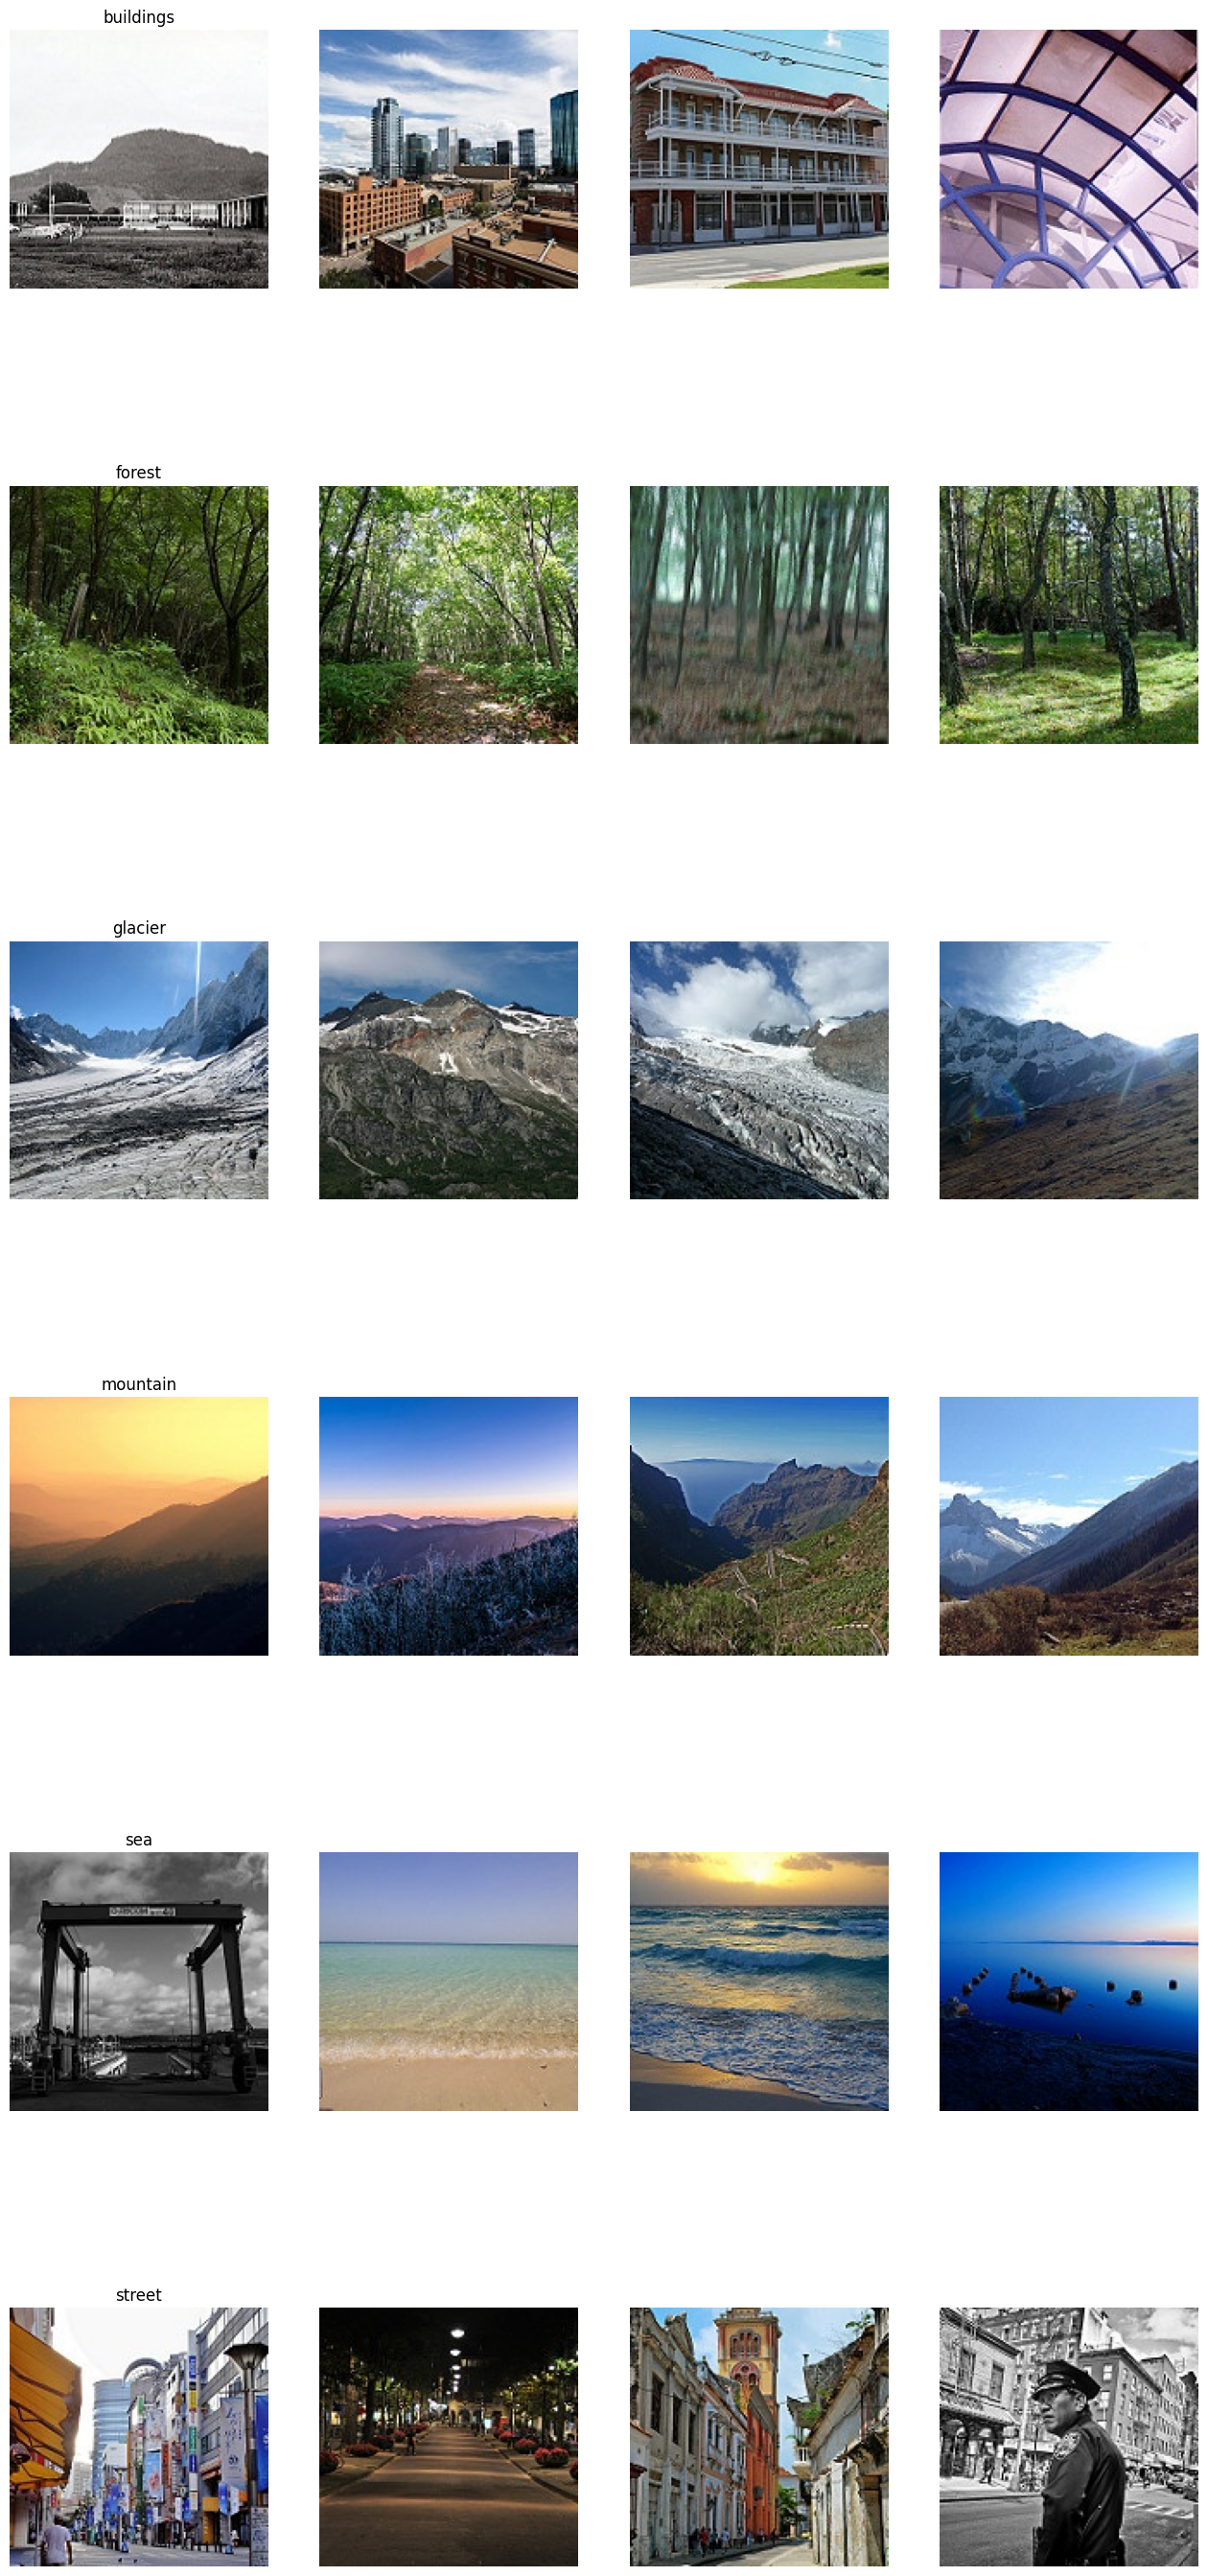

In [5]:
base_dir = r'C:\Users\rafid\OneDrive\Desktop\VSCode\Python\Image Classification\Datasets\Intel Image Classification\seg_train\seg_train'

rows = 6
cols = 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(cols * 4, rows * 6)

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

all_images = []
for class_name in classes:
    class_path = os.path.join(base_dir, class_name)
    image_paths = [os.path.join(class_path, fname) for fname in os.listdir(class_path)
                   if fname.lower().endswith(valid_extensions)][pic_index:pic_index + 4]
   
    all_images.extend(image_paths)
                       

for i, img_path in enumerate(all_images):
  sp = plt.subplot(rows, cols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)

  if i % 4 == 0:
      sp.title.set_text(classes[i // 4])

  
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(
    'C:/Users/rafid/OneDrive/Desktop/VSCode/Python/Image Classification/Datasets/Intel Image Classification/seg_train/seg_train/',
    subset = 'training',
    target_size = (150, 150),
    batch_size = BS,
    class_mode = 'categorical',
    seed = 1,
    color_mode = 'rgb',
    shuffle=True)

validation_generator = train_datagen.flow_from_directory(
    'C:/Users/rafid/OneDrive/Desktop/VSCode/Python/Image Classification/Datasets/Intel Image Classification/seg_train/seg_train/',
    subset = 'validation',
    target_size = (150, 150),
    batch_size = BS,
    class_mode = 'categorical',
    seed = 1,
    color_mode = 'rgb',
    shuffle=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    'C:/Users/rafid/OneDrive/Desktop/VSCode/Python/Image Classification/Datasets/Intel Image Classification/seg_test/seg_test/',
    target_size = (150, 150),
    batch_size = BS,
    class_mode = 'categorical',
    seed = 1,
    color_mode = 'rgb',
    shuffle = False)

x_batch, y_batch = next(train_generator)
print("Shape of images (x_batch):", x_batch.shape)  
print("Shape of labels (y_batch):", y_batch.shape)   


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Shape of images (x_batch): (32, 150, 150, 3)
Shape of labels (y_batch): (32, 6)


In [7]:
from keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model


DenseNet = DenseNet121(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)

for layer in DenseNet.layers: 
    layer.trainable = False
    
x = Dense(1024, activation = 'relu')(DenseNet.output)
x = Dropout(DROPOUT_RATE)(x)
predictions = Dense(6, activation = 'softmax')(x)

model = Model(inputs = DenseNet.input, outputs = predictions)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.4, patience=5, min_lr= 0.00001, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0, patience=10, restore_best_weights=True, verbose=2)

callbacks_list = [rlrop, early_stop]

model.compile(optimizer=Adam(learning_rate=ADAM_LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

print(model.output_shape)  # Should match (None, no_of_classes)
print(train_generator.num_classes)  # Number of classes detected
print(validation_generator.num_classes)  # Should match train_generator.num_classes


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1/conv[0][0]']         

In [8]:
history = model.fit(
    x = train_generator,
    validation_data = validation_generator,
    shuffle = True,
    epochs = EPOCHS,
    steps_per_epoch = 11230//BS,
    validation_steps =  2804//BS,
    callbacks = callbacks_list,
)

Epoch 1/50
350/350 [==============================] - 436s 1s/step - loss: 0.4142 - accuracy: 0.8555 - val_loss: 0.3029 - val_accuracy: 0.8872 - lr: 0.0010
Epoch 2/50
350/350 [==============================] - 88s 252ms/step - loss: 0.2941 - accuracy: 0.8915 - val_loss: 0.3194 - val_accuracy: 0.8861 - lr: 0.0010
Epoch 3/50
350/350 [==============================] - 71s 204ms/step - loss: 0.2725 - accuracy: 0.9003 - val_loss: 0.3334 - val_accuracy: 0.8822 - lr: 0.0010
Epoch 4/50
350/350 [==============================] - 69s 198ms/step - loss: 0.2451 - accuracy: 0.9064 - val_loss: 0.2797 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 5/50
350/350 [==============================] - 69s 198ms/step - loss: 0.2467 - accuracy: 0.9089 - val_loss: 0.2803 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 6/50
350/350 [==============================] - 69s 197ms/step - loss: 0.2370 - accuracy: 0.9092 - val_loss: 0.2785 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 7/50
350/350 [==============================] - 

In [9]:
Test_results = model.evaluate_generator(test_generator, steps=len(test_generator)//BS)
print('Test Loss, Test Accuracy: ', Test_results)

C:\Users\rafid\AppData\Local\Temp\ipykernel_6048\1654593704.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  Test_results = model.evaluate_generator(test_generator, steps=len(test_generator)//BS)


Test Loss, Test Accuracy:  [0.1970898061990738, 0.9375]


In [10]:
Validation_results = model.evaluate_generator(validation_generator, steps=len(validation_generator)//BS)
print('Validation Loss, Validation Accuracy: ', Validation_results)

C:\Users\rafid\AppData\Local\Temp\ipykernel_6048\1334199480.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  Validation_results = model.evaluate_generator(validation_generator, steps=len(validation_generator)//BS)


Validation Loss, Validation Accuracy:  [0.4867863655090332, 0.890625]


Classifier
────────────────────────────────────────────────────────────
Train Accuracy:  0.950
Train Loss:  0.132
Validation Accuracy:  0.901
Validation Loss:  0.274
Test Accuracy: 0.909
Test Loss: 0.234
────────────────────────────────────────────────────────────
Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.90      0.92       437
      forest       0.99      0.98      0.99       474
     glacier       0.81      0.89      0.85       553
    mountain       0.88      0.80      0.84       525
         sea       0.94      0.96      0.95       510
      street       0.92      0.93      0.93       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



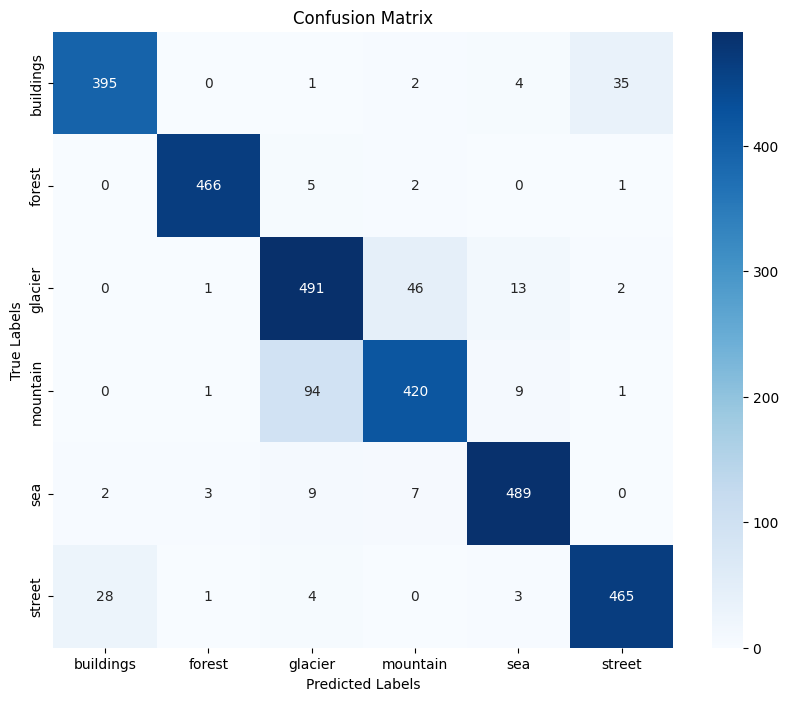

────────────────────────────────────────────────────────────
Accuracy Score (Manual Check): 0.909


In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

best_accuracy_index = np.argmax(history.history['accuracy'])
best_train_accuracy = max(history.history['accuracy'])
best_train_loss = history.history['loss'][best_accuracy_index]

validation_loss, validation_accuracy = model.evaluate(validation_generator, verbose=0)

predictions = model.predict(test_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1) 
true_classes = test_generator.classes               
class_labels = list(test_generator.class_indices.keys())  

print("Classifier")
print("─" * 60)
print('Train Accuracy: ', "{:.3f}".format(best_train_accuracy))
print('Train Loss: ', "{:.3f}".format(best_train_loss))
print('Validation Accuracy: ', "{:.3f}".format(validation_accuracy))
print('Validation Loss: ', "{:.3f}".format(validation_loss))
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test Loss: {test_loss:.3f}")
print("─" * 60)

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("─" * 60)
print("Accuracy Score (Manual Check): {:.3f}".format(accuracy_score(true_classes, predicted_classes)))


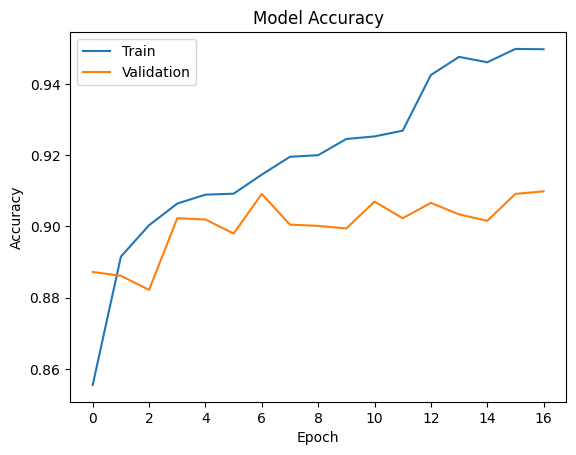

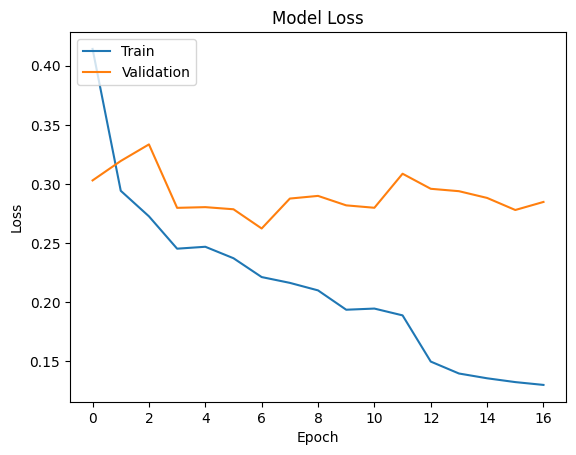

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % Test_results[1]
model.save('/Users/rafid/OneDrive/Desktop/VSCode/Python/Image Classification/Saved Models/' + 'DenseNet' + epoch_str + test_acc + '.h5')